<a href="https://colab.research.google.com/github/jihyeon602/SQL_practice/blob/main/Chroma_Vector_Database_medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼

In [ ]:
!pip install -q chromadb transformers==4.38.2

## Dataset

식약품 데이터: 22개종 40장씩

In [3]:
!unzip -q /content/drive/MyDrive/프로젝트_알약인식/medicine.zip -d /content/medicine/

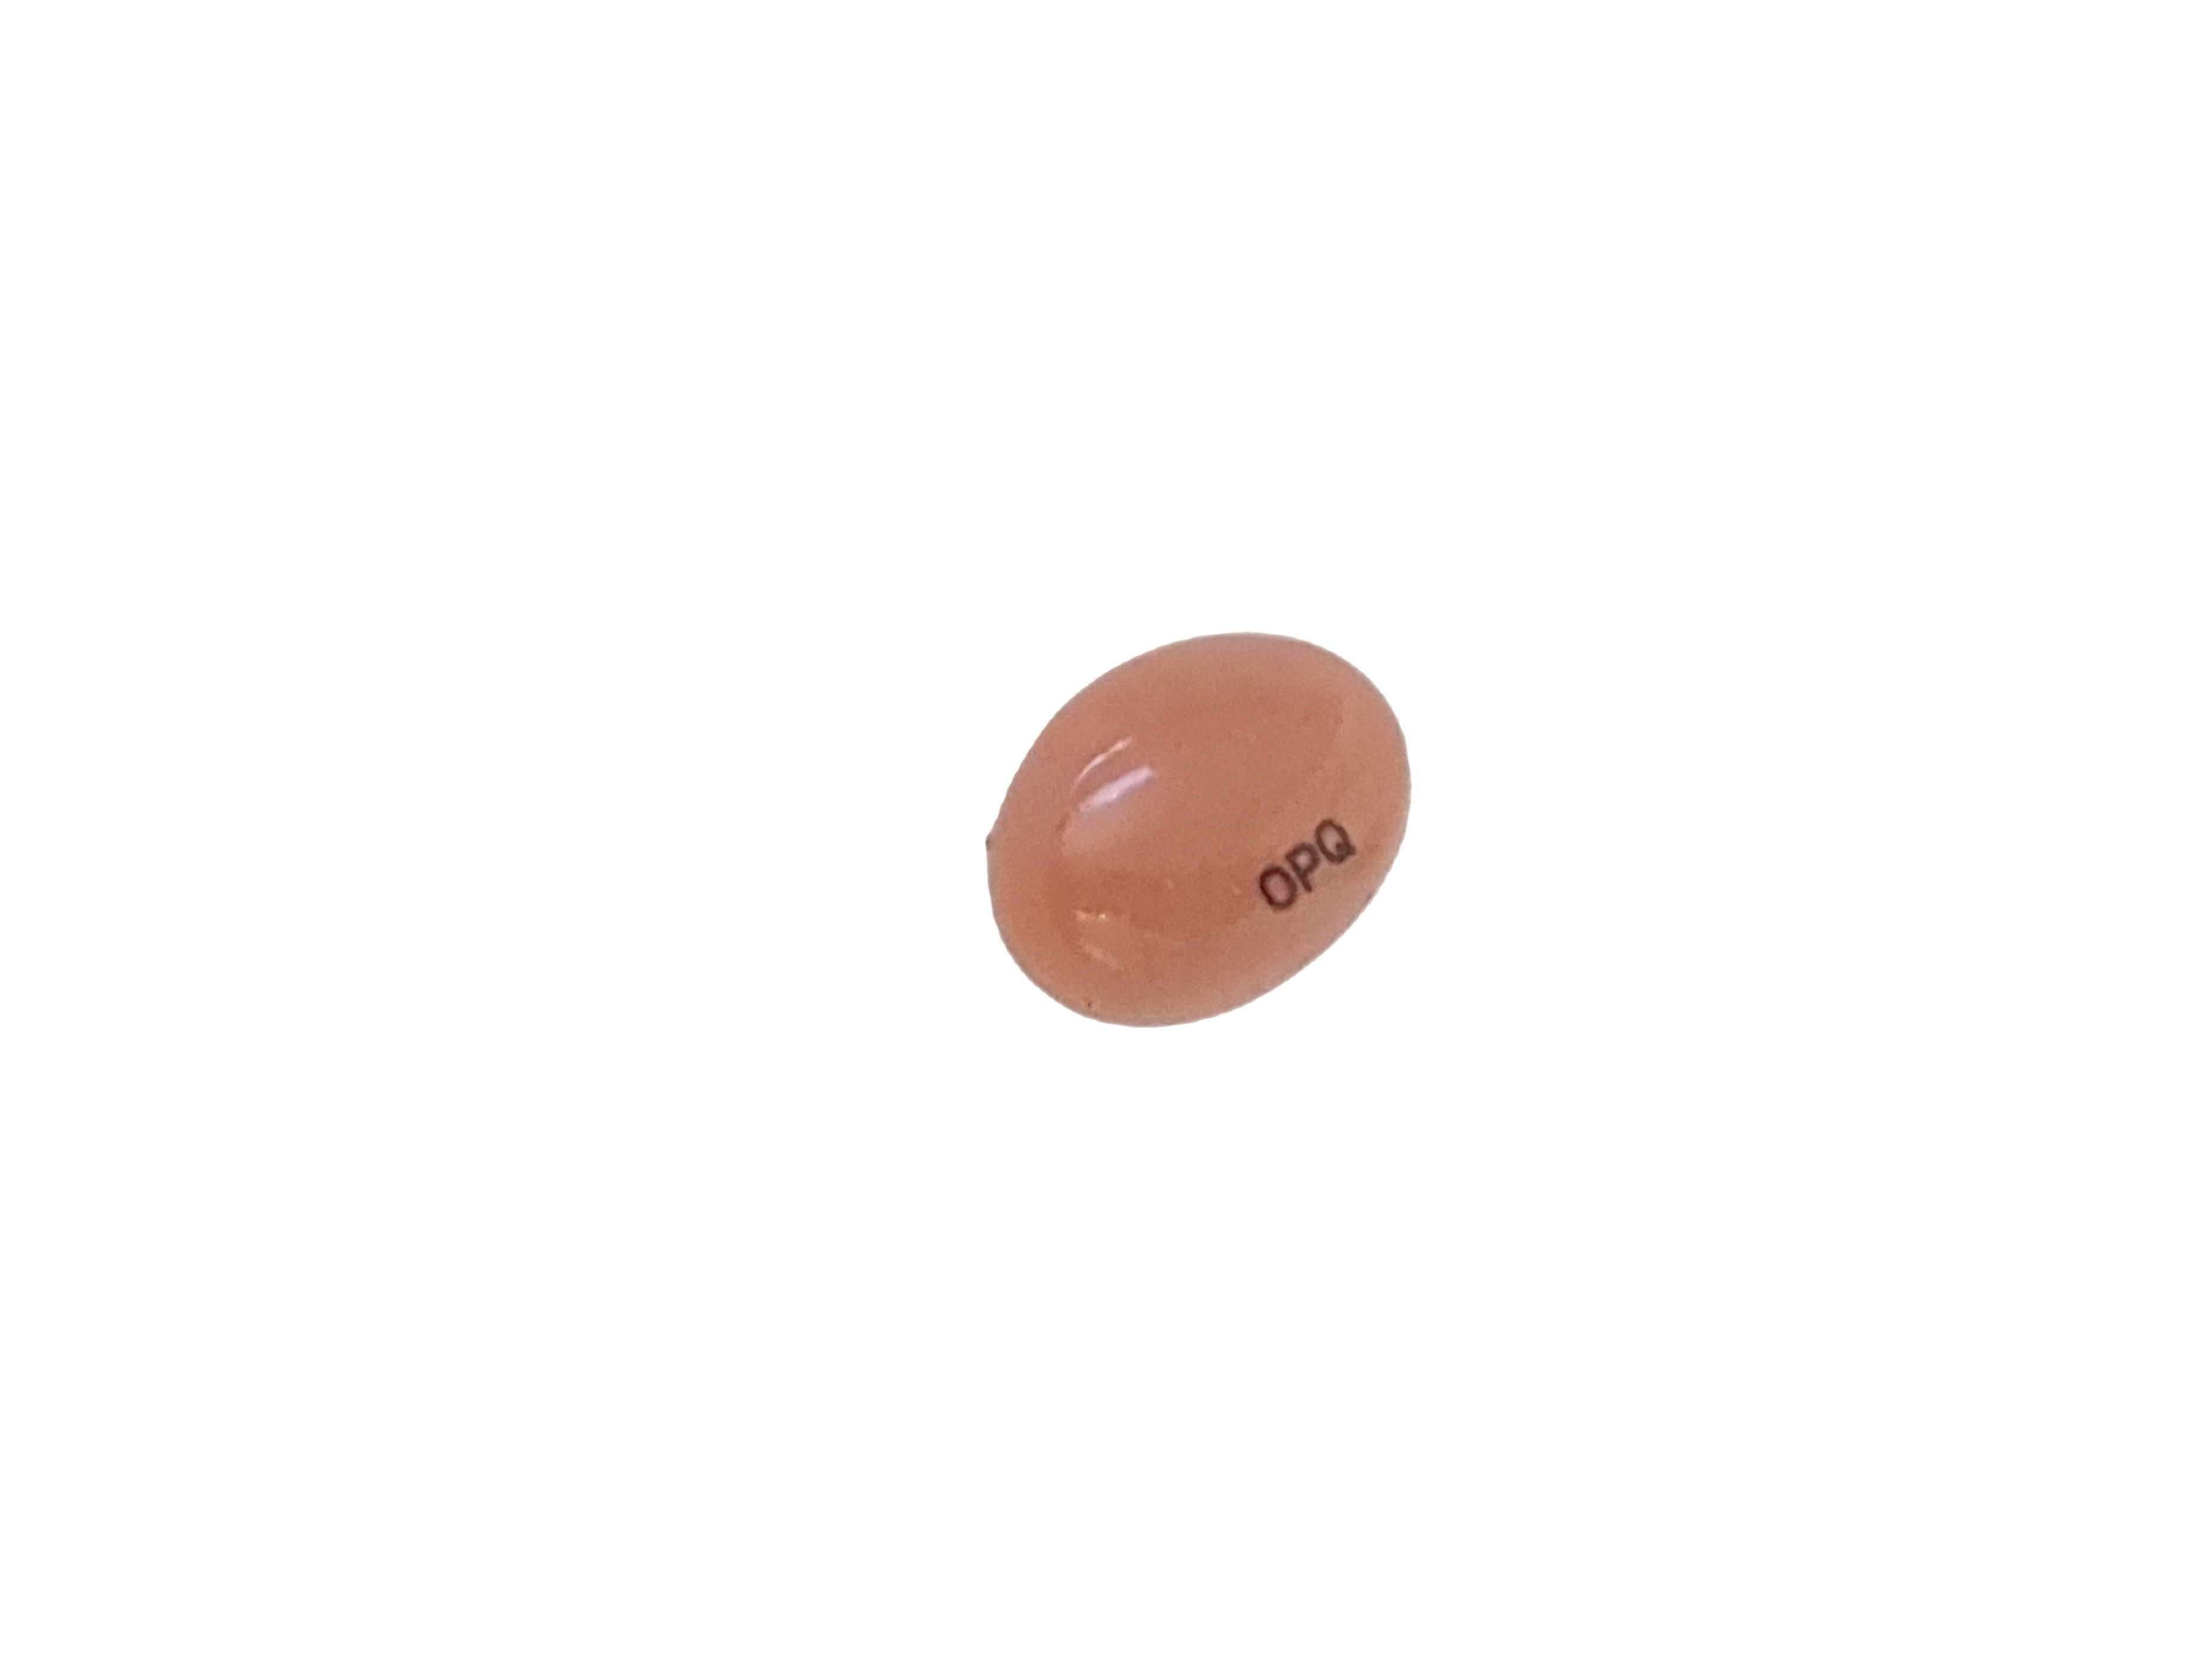

In [4]:
from PIL import Image

img = Image.open("/content/medicine/29002/IMG_20201202_163857.png")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [5]:
from transformers import ViTImageProcessor, ViTModel

feature_extractor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [11]:
img = Image.open("/content/medicine/39916/2020-10-29-20-52-12-081.png").convert("RGB")
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

array([-0.98164237, -0.9224988 , -0.80700946, -0.9943882 ,  0.9863242 ,
       -0.93723136, -0.73607486,  0.99547666,  0.9698064 ,  0.84411186,
       -0.8919611 ,  0.9619199 ,  0.39454108, -0.5910637 ,  0.88190126,
       -0.90978426, -0.9996961 , -0.2646381 , -0.16446601, -0.43662593,
       -0.07774393, -0.6094083 ,  0.815009  , -0.9438912 , -0.5017987 ,
       -0.8499133 ,  0.99713576,  0.6334578 , -0.9863869 , -0.9801752 ,
       -0.95213044,  0.9949605 , -0.7771063 , -0.3419559 , -0.4435767 ,
       -0.3873694 ,  0.9938786 ,  0.99004596, -0.9909512 ,  0.15463302,
        0.91355664, -0.90004814,  0.9564183 ,  0.99520135, -0.9128313 ,
       -0.01596971,  0.9181675 , -0.9969078 , -0.47380194, -0.36536923,
       -0.99078315,  0.566123  ,  0.97286975,  0.983034  , -0.8614251 ,
        0.9238033 ,  0.72323525,  0.7639426 ,  0.8522791 ,  0.9894817 ,
       -0.8067844 , -0.9856013 ,  0.21408479, -0.84702003, -0.73470354,
       -0.9174835 , -0.11397076,  0.6948094 , -0.94272494, -0.98

In [12]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
!pip install chromadb

In [17]:
import chromadb

client = chromadb.PersistentClient(path="/content/chroma_medicine_db")

collection = client.get_or_create_collection("medicine")

## 모든 이미지 벡터화

In [19]:
from glob import glob

img_list = sorted(glob("/content/medicine/*/*.png"))

len(img_list)

920

In [21]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path).convert("RGB")
    cls = img_path.split("/")[-2]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 920/920 [04:29<00:00,  3.41it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [22]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

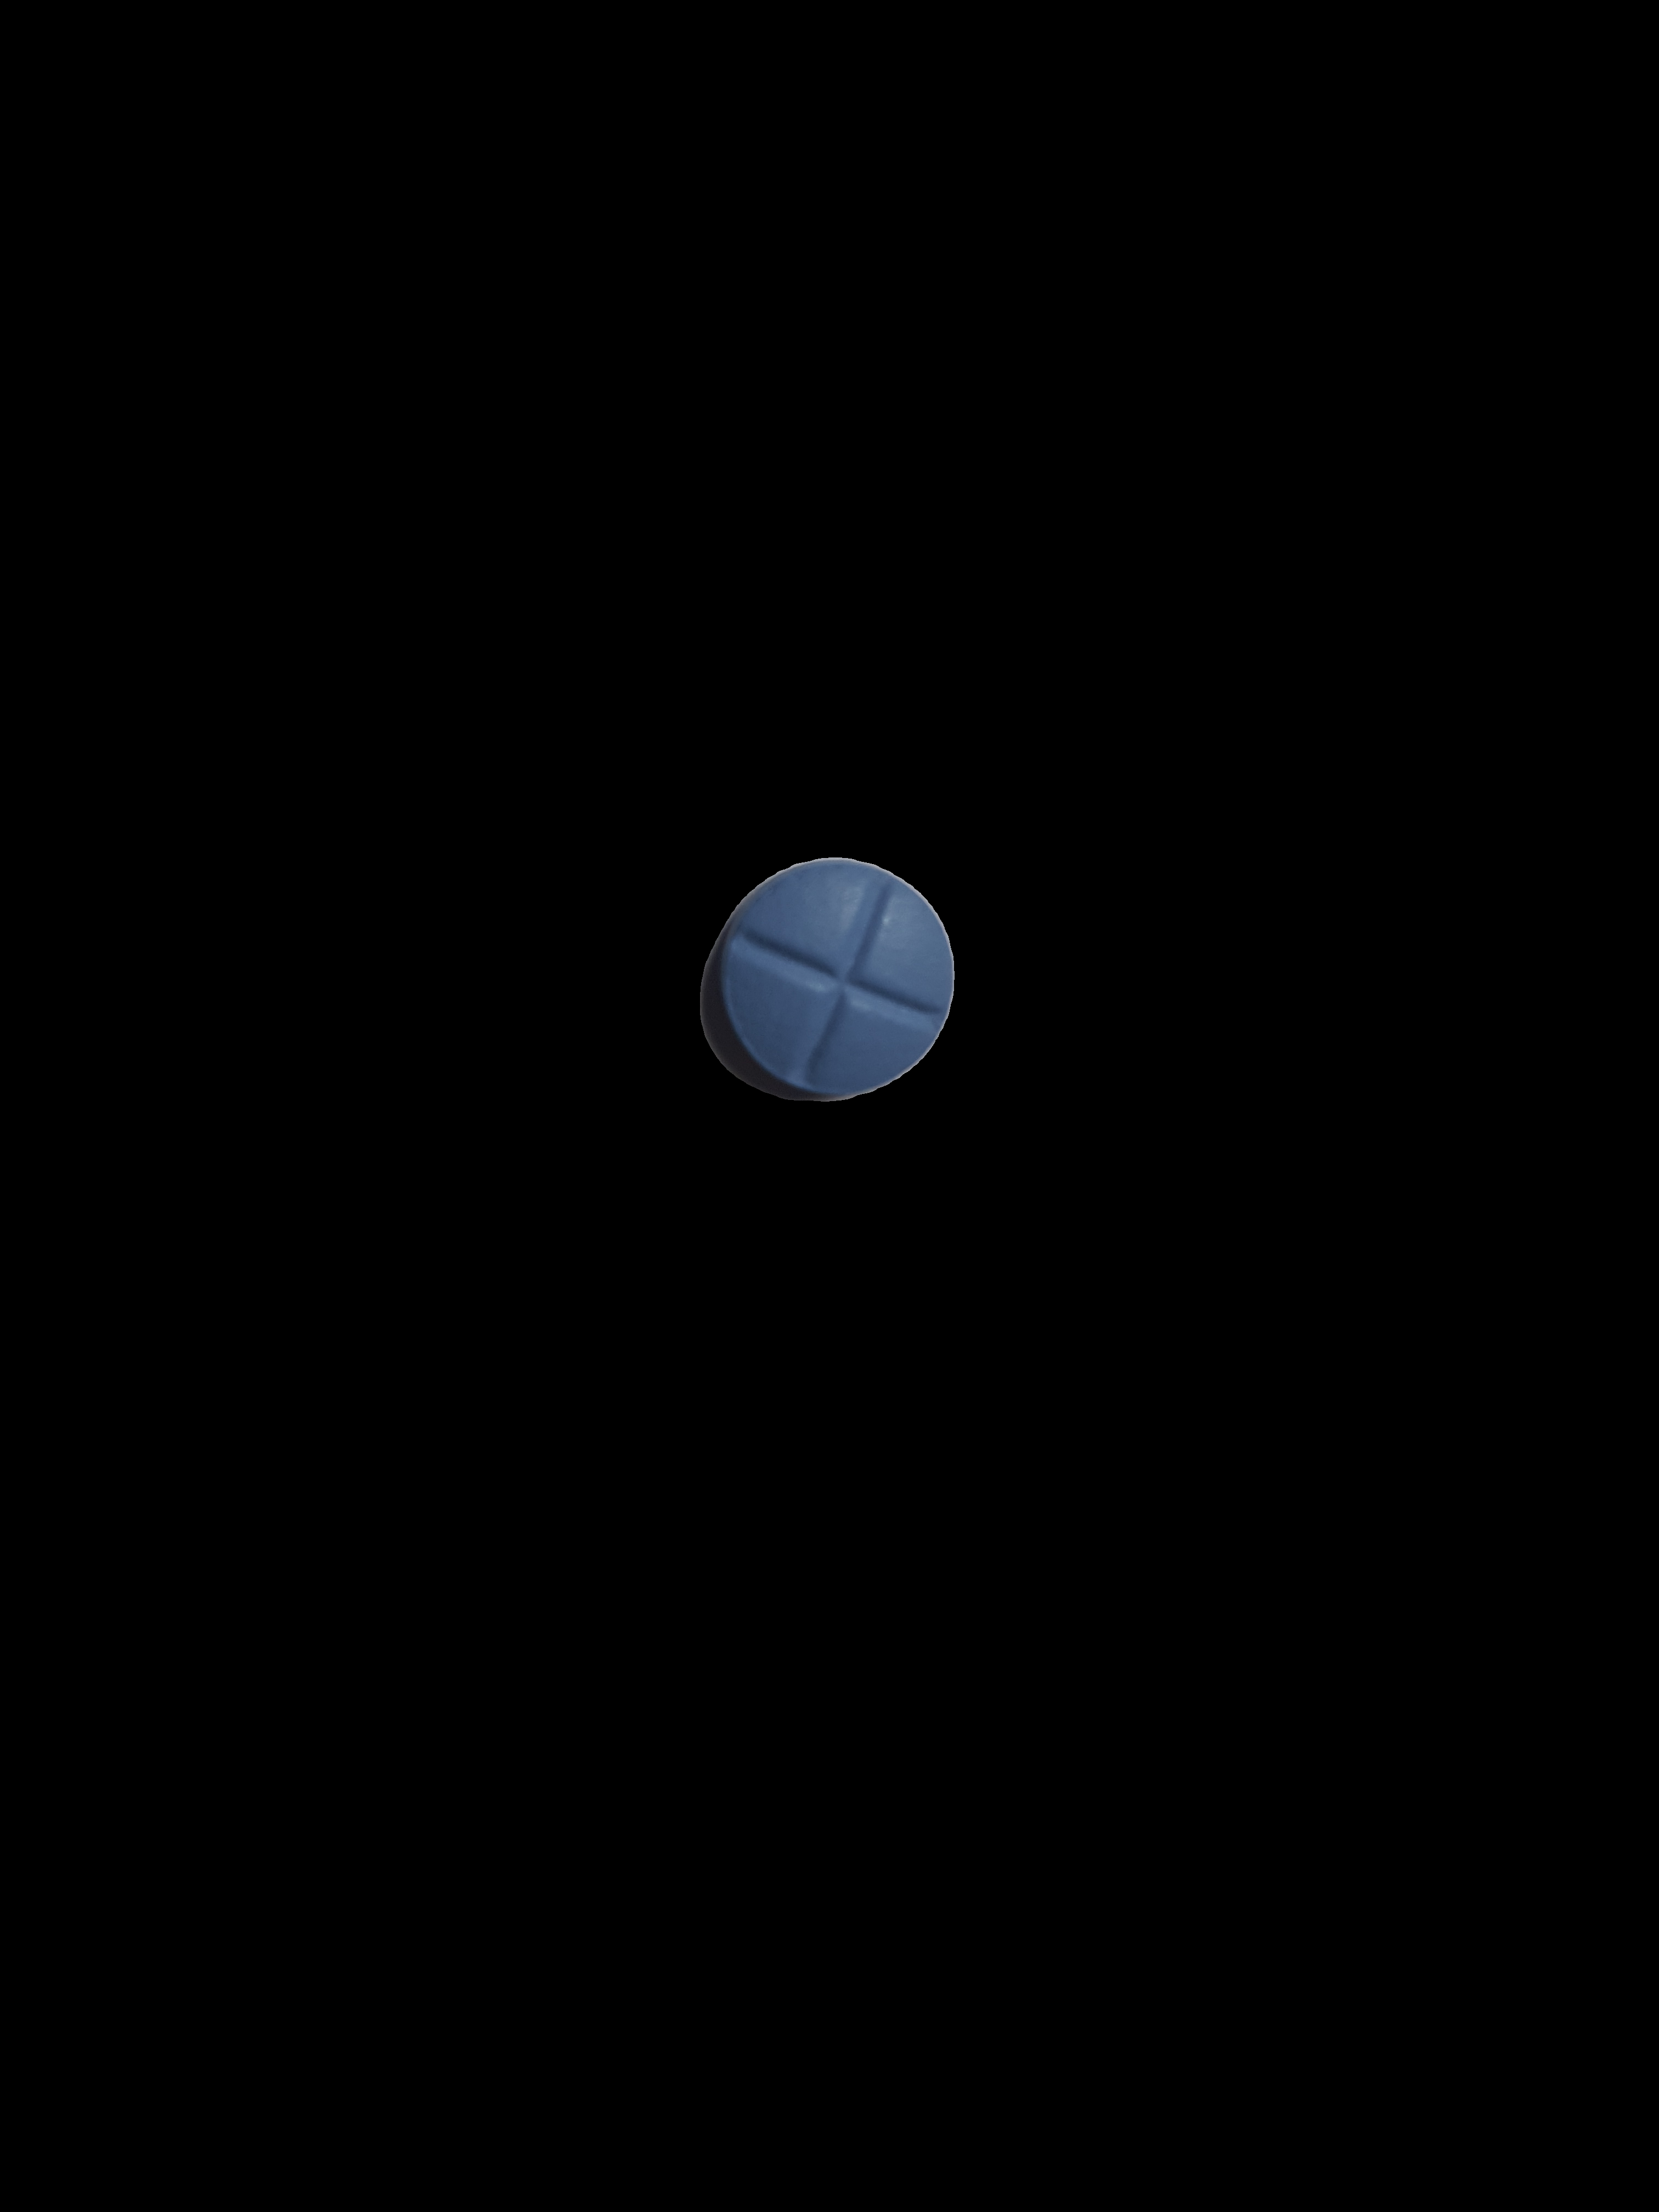

In [24]:
import requests

test_img = Image.open("/content/medicine/39916/2020-10-29-20-53-16-977.png").convert("RGB")

test_img

In [25]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding_list = test_embedding.tolist()

test_embedding.shape

(384,)

In [26]:
query_result = collection.query(
    query_embeddings=[test_embedding_list],
    n_results=3,
)

query_result

{'ids': [['193', '194', '181']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': '39916',
    'uri': '/content/medicine/39916/2020-10-29-20-53-16-977.png'},
   {'name': '39916',
    'uri': '/content/medicine/39916/2020-10-29-20-53-17-978.png'},
   {'uri': '/content/medicine/39916/2020-10-29-20-53-04-959.png',
    'name': '39916'}]],
 'distances': [[0.0, 7.014610290527344, 10.232662200927734]]}

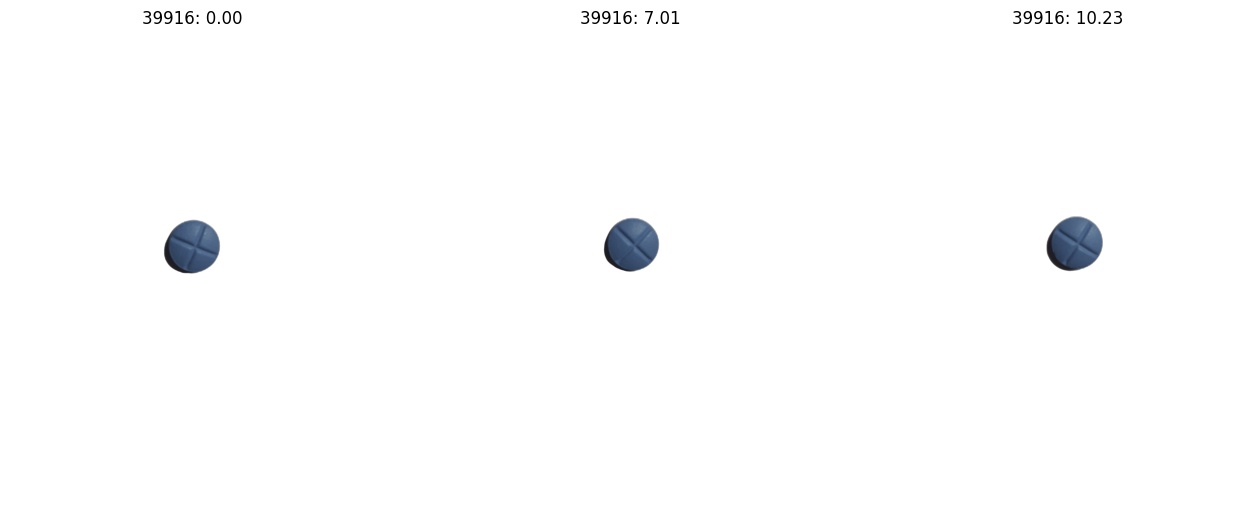

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [28]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

In [66]:
def query_local(img_path, n_results=3):
    # ✅ 로컬 이미지 불러오기 (requests 필요 없음)
    test_img = Image.open(img_path).convert("RGB")

    # ✅ 이미지 전처리 + CUDA 전송
    inputs = feature_extractor(images=test_img, return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    test_embedding = outputs.pooler_output.detach().cpu().numpy().squeeze().tolist()

    # ✅ ChromaDB 쿼리
    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    # ✅ 시각화
    fig, axes = plt.subplots(1, n_results + 1, figsize=(5 * (n_results + 1), 5))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        result_img = Image.open(metadata["uri"])
        axes[i + 1].imshow(result_img)
        axes[i + 1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    return query_result

## Test2

{'ids': [['683', '691', '700']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'uri': '/content/medicine/41170/IMG_20201117_220657.png',
    'name': '41170'},
   {'uri': '/content/medicine/41170/IMG_20201117_220707.png', 'name': '41170'},
   {'uri': '/content/medicine/41170/IMG_20201117_220724.png',
    'name': '41170'}]],
 'distances': [[295.34893798828125, 296.09271240234375, 297.3760986328125]]}

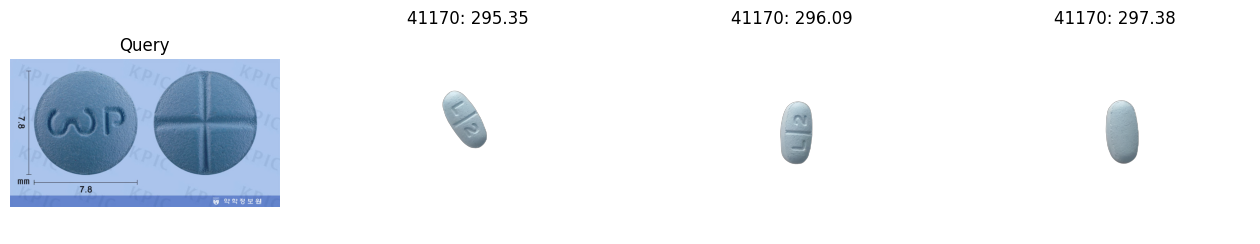

In [31]:
query("https://common.health.kr/shared/images/sb_photo/big3/201906270003601.jpg")

{'ids': [['292', '306', '305']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': '40767',
    'uri': '/content/medicine/40767/IMG_20201125_132750.png'},
   {'name': '40767', 'uri': '/content/medicine/40767/IMG_20201125_132817.png'},
   {'uri': '/content/medicine/40767/IMG_20201125_132816.png',
    'name': '40767'}]],
 'distances': [[259.7682189941406, 261.29595947265625, 261.87054443359375]]}

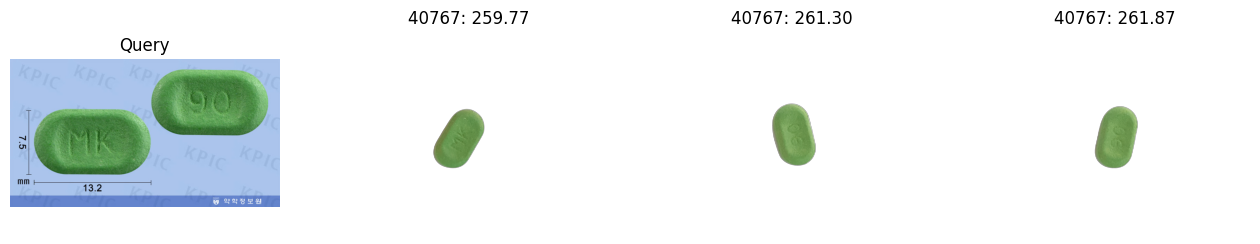

In [36]:
query("https://www.pharm.or.kr/images/sb_photo/big3/201901250011601.jpg")

{'ids': [['150', '157', '143']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'uri': '/content/medicine/37990/IMG_20201209_170701.png',
    'name': '37990'},
   {'name': '37990', 'uri': '/content/medicine/37990/IMG_20201209_170710.png'},
   {'uri': '/content/medicine/37990/IMG_20201209_170651.png',
    'name': '37990'}]],
 'distances': [[250.3892822265625, 263.78509521484375, 265.35308837890625]]}

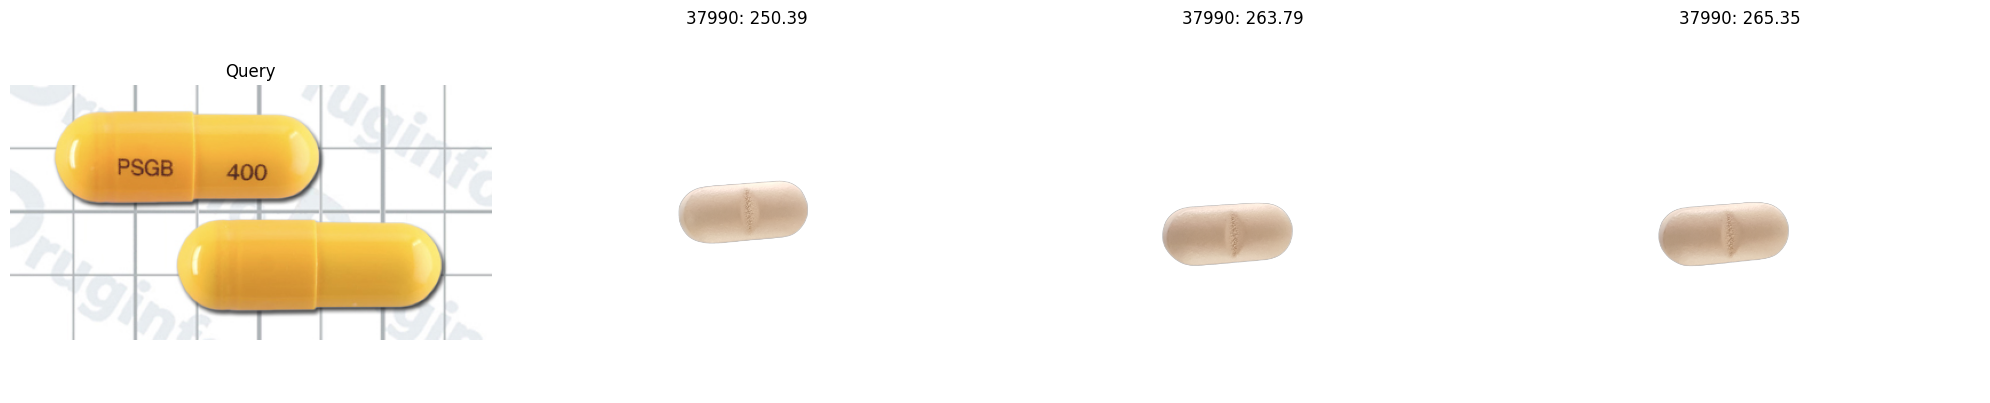

In [40]:
query_local("/content/243715.jpg")

{'ids': [['322', '150', '143']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'uri': '/content/medicine/40792/IMG_20201201_202817.png',
    'name': '40792'},
   {'uri': '/content/medicine/37990/IMG_20201209_170701.png', 'name': '37990'},
   {'name': '37990',
    'uri': '/content/medicine/37990/IMG_20201209_170651.png'}]],
 'distances': [[216.74453735351562, 217.67739868164062, 232.95811462402344]]}

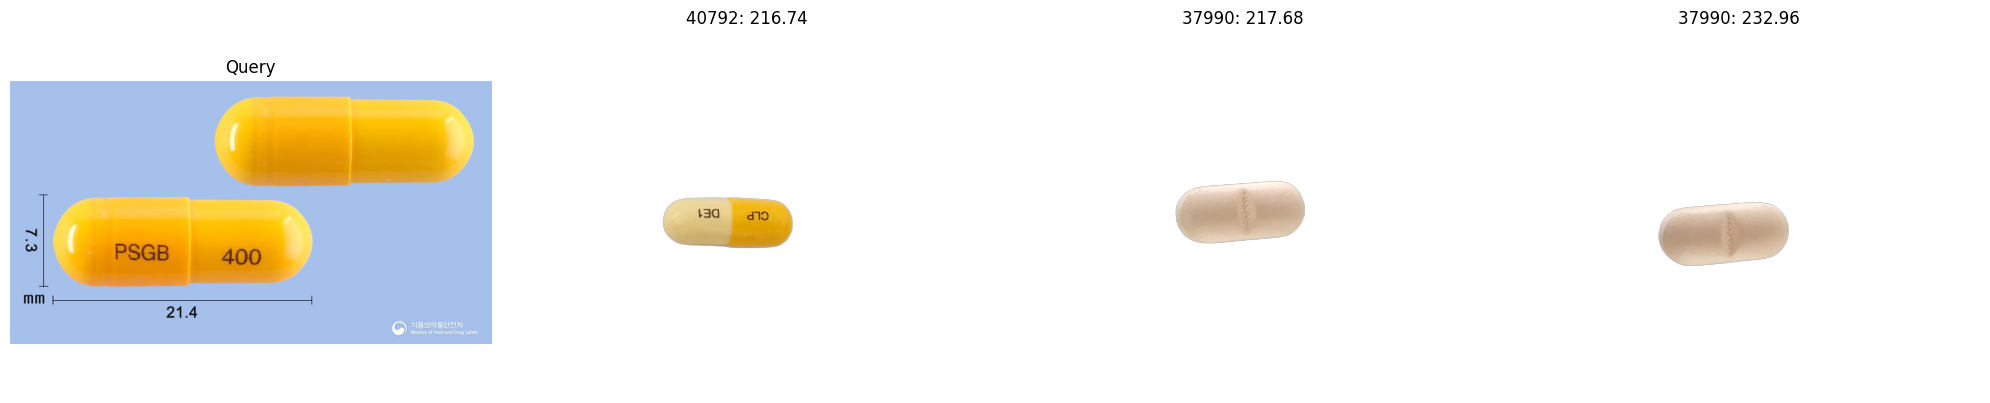

In [43]:
query_local("/content/202001290002202.jpg")

In [68]:
import chromadb
client_chroma = chromadb.PersistentClient(path="/content/chroma_medicine_db")
chroma_collection = client_chroma.get_or_create_collection("medicine")


In [101]:
def query_local2(img_path, n_results=3):
    from PIL import Image
    import torch
    import matplotlib.pyplot as plt

    # ✅ 로컬 이미지 불러오기
    test_img = Image.open(img_path).convert("RGB")

    # ✅ 이미지 전처리 + CUDA 전송
    inputs = feature_extractor(images=test_img, return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    test_embedding = outputs.pooler_output.detach().cpu().numpy().squeeze().tolist()

    # ✅ ChromaDB 쿼리 (collection → chroma_collection)
    query_result = chroma_collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    # ✅ 시각화
    fig, axes = plt.subplots(1, n_results + 1, figsize=(5 * (n_results + 1), 5))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        result_img = Image.open(metadata["uri"])
        axes[i + 1].imshow(result_img)
        axes[i + 1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    return query_result


{'ids': [['322', '334', '806']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': '40792',
    'uri': '/content/medicine/40792/IMG_20201201_202817.png'},
   {'name': '40792', 'uri': '/content/medicine/40792/IMG_20201201_202835.png'},
   {'name': '41225',
    'uri': '/content/medicine/41225/IMG_20201117_193259.png'}]],
 'distances': [[251.8663330078125, 264.2360534667969, 265.4778747558594]]}

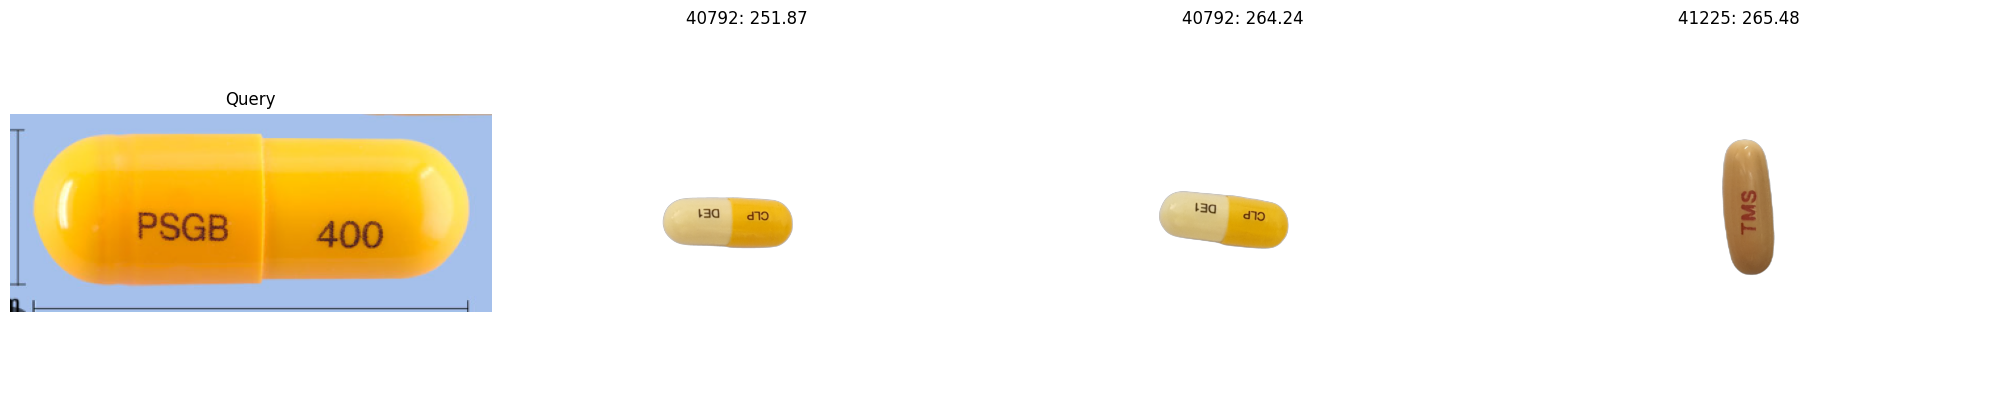

In [70]:
query_local2("/content/CUT.png")

- Query 이미지와 실제 데이터셋 내 알약 이미지 간 시각적 유사도가 높음에도 불구하고 모델이 근접하지 않은 결과를반환한 것으로 보 현재 사용 중인 이미지 임베딩 기반 검색 성능이 제한적인 것으로 보임

### MongoDB로 이동

In [54]:
from pymongo import MongoClient

# 예: MongoDB Atlas 접속 (실제 정보로 바꿔야 함)
client = MongoClient("[YOUR_URL]")

# 또는 로컬 Docker MongoDB
# client = MongoClient("mongodb://localhost:27017/")

db = client["medicine_db"]
collection = db["pill_embeddings"]


In [55]:
import chromadb

# ChromaDB 연결
chroma_client = chromadb.PersistentClient(path="/content/chroma_medicine_db")
chroma_collection = chroma_client.get_collection("medicine")

# 전체 데이터 불러오기
chroma_data = chroma_collection.get(
    include=["embeddings", "metadatas", "documents"]
)

print(f"🔢 총 {len(chroma_data['ids'])}개 데이터 이관 예정")


🔢 총 920개 데이터 이관 예정


In [58]:
import numpy as np

for i in range(len(chroma_data["ids"])):
    record = {
        "_id": chroma_data["ids"][i],
        "embedding": (
            chroma_data["embeddings"][i].tolist()  # ✅ NumPy → list
            if isinstance(chroma_data["embeddings"][i], np.ndarray)
            else chroma_data["embeddings"][i]
        ),
        "metadata": chroma_data["metadatas"][i],
        "document": chroma_data["documents"][i] if chroma_data["documents"] else None
    }

    # MongoDB upsert
    collection.update_one({"_id": record["_id"]}, {"$set": record}, upsert=True)


print("✅ MongoDB로 이관 완료")


✅ MongoDB로 이관 완료


In [59]:
# 현재 총 문서 수 확인
print("총 저장된 문서 수:", collection.count_documents({}))


총 저장된 문서 수: 920


In [60]:
for doc in collection.find().limit(3):
    print(doc)

{'_id': '0', 'document': None, 'embedding': [-0.9960619211196899, -0.9867194294929504, 0.3207413852214813, -0.990998387336731, 0.9781447052955627, -0.6767253875732422, -0.8895832896232605, 0.9955922961235046, 0.9939520955085754, 0.9977595210075378, -0.9846383929252625, 0.8775724172592163, -0.3318910598754883, -0.9688764810562134, -0.6549861431121826, -0.968476414680481, -0.9670576453208923, -0.8903008699417114, -0.7999458312988281, -0.9764266610145569, 0.3201366364955902, 0.43988075852394104, 0.9289814829826355, -0.7753831148147583, -0.9433385133743286, -0.020137984305620193, 0.9351165294647217, -0.21841371059417725, -0.9985888600349426, -0.9484666585922241, 0.5893820524215698, 0.9320488572120667, -0.9836080074310303, -0.6254018545150757, -0.8376023769378662, 0.6409298181533813, -0.12657205760478973, 0.9410597085952759, -0.9992335438728333, 0.7409971952438354, 0.7516405582427979, -0.16932831704616547, -0.8281108140945435, 0.9992049932479858, -0.6237282752990723, -0.8235324025154114, 0.

## 쿼리 결과 mongoDB에 저장

In [63]:
from datetime import datetime
from pymongo import MongoClient
import requests
from PIL import Image
import matplotlib.pyplot as plt

# ✅ ChromaDB 컬렉션
client_chroma = chromadb.PersistentClient(path="/content/chroma_medicine_db")
chroma_collection = client_chroma.get_or_create_collection("medicine")  # client_chroma는 Chroma PersistentClient

# ✅ MongoDB 연결
client_mongo = MongoClient("{YOUR_URL}")
db = client_mongo["medicine_db"]
log_collection = db["query_logs"]

def query_DB(img_url, n_results=3):
    # 이미지 로딩
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    # 임베딩 추출
    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)
    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    # ✅ Chroma 검색
    query_result = chroma_collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    # 시각화
    fig, axes = plt.subplots(1, n_results + 1, figsize=(4 * (n_results + 1), 10))
    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    # 로그 문서 생성
    log_document = {
        "query_time": datetime.now().isoformat(),
        "query_url": img_url,
        "results": []
    }

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]
        match_id = query_result["ids"][0][i]

        axes[i + 1].imshow(Image.open(metadata["uri"]))
        axes[i + 1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i + 1].axis("off")

        log_document["results"].append({
            "id": match_id,
            "name": metadata["name"],
            "uri": metadata["uri"],
            "distance": distance
        })

    # ✅ MongoDB에 로그 저장
    log_collection.insert_one(log_document)
    print("✅ Query result logged to MongoDB.")

    return query_result


✅ Query result logged to MongoDB.


{'ids': [['292', '306', '305']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': '40767',
    'uri': '/content/medicine/40767/IMG_20201125_132750.png'},
   {'uri': '/content/medicine/40767/IMG_20201125_132817.png', 'name': '40767'},
   {'uri': '/content/medicine/40767/IMG_20201125_132816.png',
    'name': '40767'}]],
 'distances': [[259.7682189941406, 261.29595947265625, 261.87054443359375]]}

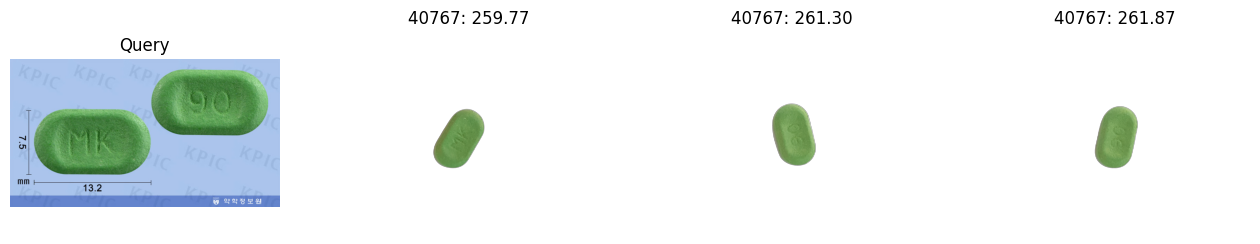

In [64]:
query_DB("https://www.pharm.or.kr/images/sb_photo/big3/201901250011601.jpg")

#ai-hub 학습된 모델 이용하기

In [84]:
import torch

data = torch.load("/content/drive/MyDrive/프로젝트_알약인식/pill_resnet152_dataclass1_aug0.pt")  # CUDA 안 쓰면 map_location 필요
type(data)

dict

In [85]:
print(data.keys())


dict_keys(['epoch', 'model', 'optimizer'])


In [86]:
for k, v in data.items():
    print(f"{k}: {type(v)} | shape: {getattr(v, 'shape', 'N/A')}")

epoch: <class 'int'> | shape: N/A
model: <class 'collections.OrderedDict'> | shape: N/A
optimizer: <class 'dict'> | shape: N/A


In [87]:
model_state_dict = data['model']
fc_weight = model_state_dict['fc.weight']  # shape: [num_classes, in_features]

num_classes = fc_weight.shape[0]
print("📦 모델이 학습한 클래스 수:", num_classes)


📦 모델이 학습한 클래스 수: 1000


In [71]:
import torch
import torch.nn as nn
from torchvision.models import resnet152
from torchvision import transforms
from PIL import Image


In [88]:
# 모델 파라미터
num_classes = 1000  # ✅ 반드시 학습 시 사용한 클래스 수로 수정

# 모델 경로
model_path = "/content/drive/MyDrive/프로젝트_알약인식/pill_resnet152_dataclass1_aug0.pt"


In [89]:
# 모델 구조 정의
model = resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 학습 weight 로드
checkpoint = torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(checkpoint["model"])  # 저장된 키: 'model'
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

print("✅ 모델 로드 완료")


✅ 모델 로드 완료


In [90]:
# 전처리 파이프라인
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0)  # [1, 3, 224, 224]
    return tensor.to("cuda" if torch.cuda.is_available() else "cpu")


In [95]:
def predict(img_path, class_names=None):
    input_tensor = preprocess_image(img_path)

    with torch.no_grad():
        output = model(input_tensor)
        pred_id = torch.argmax(output, dim=1).item()

    if class_names:
        return class_names[pred_id]
    else:
        return pred_id


In [97]:
result = predict("/content/243715.jpg")  # 알약 이미지 경로
print("예측 결과:", result)


예측 결과: 566
